In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
sys.path.append('../common')
import collect_dem

%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
font_size = 18
rc('font', size=font_size)
rc('axes', titlesize=font_size)
%config InlineBackend.figure_format = 'retina'

In [52]:
import scipy.sparse.csgraph as graph
import scipy.sparse
def tri_connectivity_graph(tris):
    n_tris = tris.shape[0]
    touching = [[] for i in range(np.max(tris) + 1)]
    for i in range(n_tris):
        for d in range(3):
            touching[tris[i,d]].append(i)
            
    rows = []
    cols = []
    for i in range(len(touching)):
        for row in touching[i]:
            for col in touching[i]:
                rows.append(row)
                cols.append(col)
    rows = np.array(rows)
    cols = np.array(cols)
    connectivity = scipy.sparse.coo_matrix((np.ones(rows.shape[0]), (rows, cols)), shape = (n_tris, n_tris))
    return connectivity
    
def get_connected_components(tris):
    return graph.connected_components(tri_connectivity_graph(tris))

def find_free_edges(tris):
    edges = dict()
    for i, t in enumerate(tris):
        for d in range(3):
            pt1_idx = t[d]
            pt2_idx = t[(d + 1) % 3]
            if pt1_idx > pt2_idx:
                pt2_idx,pt1_idx = pt1_idx,pt2_idx
            pt_pair = (pt1_idx, pt2_idx)
            edges[pt_pair] = edges.get(pt_pair, []) + [(i, d)]

    free_edges = []
    for k,e in edges.items():
        if len(e) > 1:
            continue
        free_edges.append(e[0])

    return free_edges

def get_boundary_loop(m):
    which_comp = get_connected_components(m[1])[1]
    n_surfaces = np.unique(which_comp).shape[0]
    orderings = []
    for surf_idx in range(2):
        tri_subset = m[1][which_comp == surf_idx]
        free_edges = find_free_edges(tri_subset)
        pt_to_pt = [
            (tri_subset[tri_idx, edge_idx], tri_subset[tri_idx, (edge_idx + 1) % 3])
            for tri_idx, edge_idx in free_edges
        ]

        pts_to_edges = dict()
        for i, e in enumerate(pt_to_pt):
            for lr in [0,1]:
                pts_to_edges[e[lr]] = pts_to_edges.get(e[lr], []) + [i]

        for k,v in pts_to_edges.items():
            assert(len(v) == 2)

        ordering = [pt_to_pt[0][0], pt_to_pt[0][1]]
        looped = False
        while not looped:
            pt_idx = ordering[-1]
            prev_pt_idx = ordering[-2]
            for e_idx in pts_to_edges[pt_idx]:
                edge = pt_to_pt[e_idx]
                if edge[0] == prev_pt_idx or edge[1] == prev_pt_idx:
                    continue
                if edge[0] == pt_idx:
                    ordering.append(edge[1])
                else:
                    ordering.append(edge[0])
            if ordering[-1] == ordering[0]:
                looped = True
        orderings.append(ordering)
    return orderings

def remove_unused_pts(m):
    referenced_pts = np.unique(m[1])
    new_pts = m[0][referenced_pts,:]
    new_indices = np.empty(m[0].shape[0], dtype = np.int64)
    new_indices[referenced_pts] = np.arange(referenced_pts.shape[0])
    new_tris = new_indices[m[1]]
    return (new_pts, new_tris)

def get_dem_bounds(lonlat_pts):
    minlat = np.min(lonlat_pts[:,1])
    minlon = np.min(lonlat_pts[:,0])
    maxlat = np.max(lonlat_pts[:,1])
    maxlon = np.max(lonlat_pts[:,0])
    latrange = maxlat - minlat
    lonrange = maxlon - minlon
    bounds = (
        minlat - latrange * 0.1,
        minlon - lonrange * 0.1,
        maxlat + latrange * 0.1,
        maxlon + lonrange * 0.1
    )
    return bounds

def get_pt_elevations(lonlat_pts, zoom, n_interp = 100):
    bounds = get_dem_bounds(lonlat_pts)
    LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)
    return scipy.interpolate.griddata(
        (LON, LAT), DEM, (lonlat_pts[:,0], lonlat_pts[:,1])
    )

In [20]:
#bounds = 29.361572, 98.207583, 33.579870, 106.743077
zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300
#proj = 'ellps'

In [21]:
from tectosaur.mesh.modify import remove_duplicate_pts
lon,lat,z,tris = np.load('wenchuan_fault_surf.npy', encoding = 'latin1')
pts = np.vstack((lon,lat,z)).T
pts, tris = remove_duplicate_pts((pts, tris))
which_comp = get_connected_components(tris)[1]

In [22]:
#remove the detachment
average_depth = np.zeros(3)
average_depth = np.mean(pts[tris,2], axis = 1)
component_depth = np.array([np.mean(average_depth[which_comp == d]) for d in range(3)])
detachment_component = np.where(component_depth < -21000)[0][0]
nondetachment_tris = tris[np.where(which_comp != detachment_component)[0]]

In [23]:
#remove unused pts
new_pts, new_tris = remove_unused_pts((pts, nondetachment_tris))

In [24]:
fault_pts = collect_dem.project(new_pts[:,0], new_pts[:,1], new_pts[:,2], proj)
fault_m = (fault_pts, new_tris)

48R


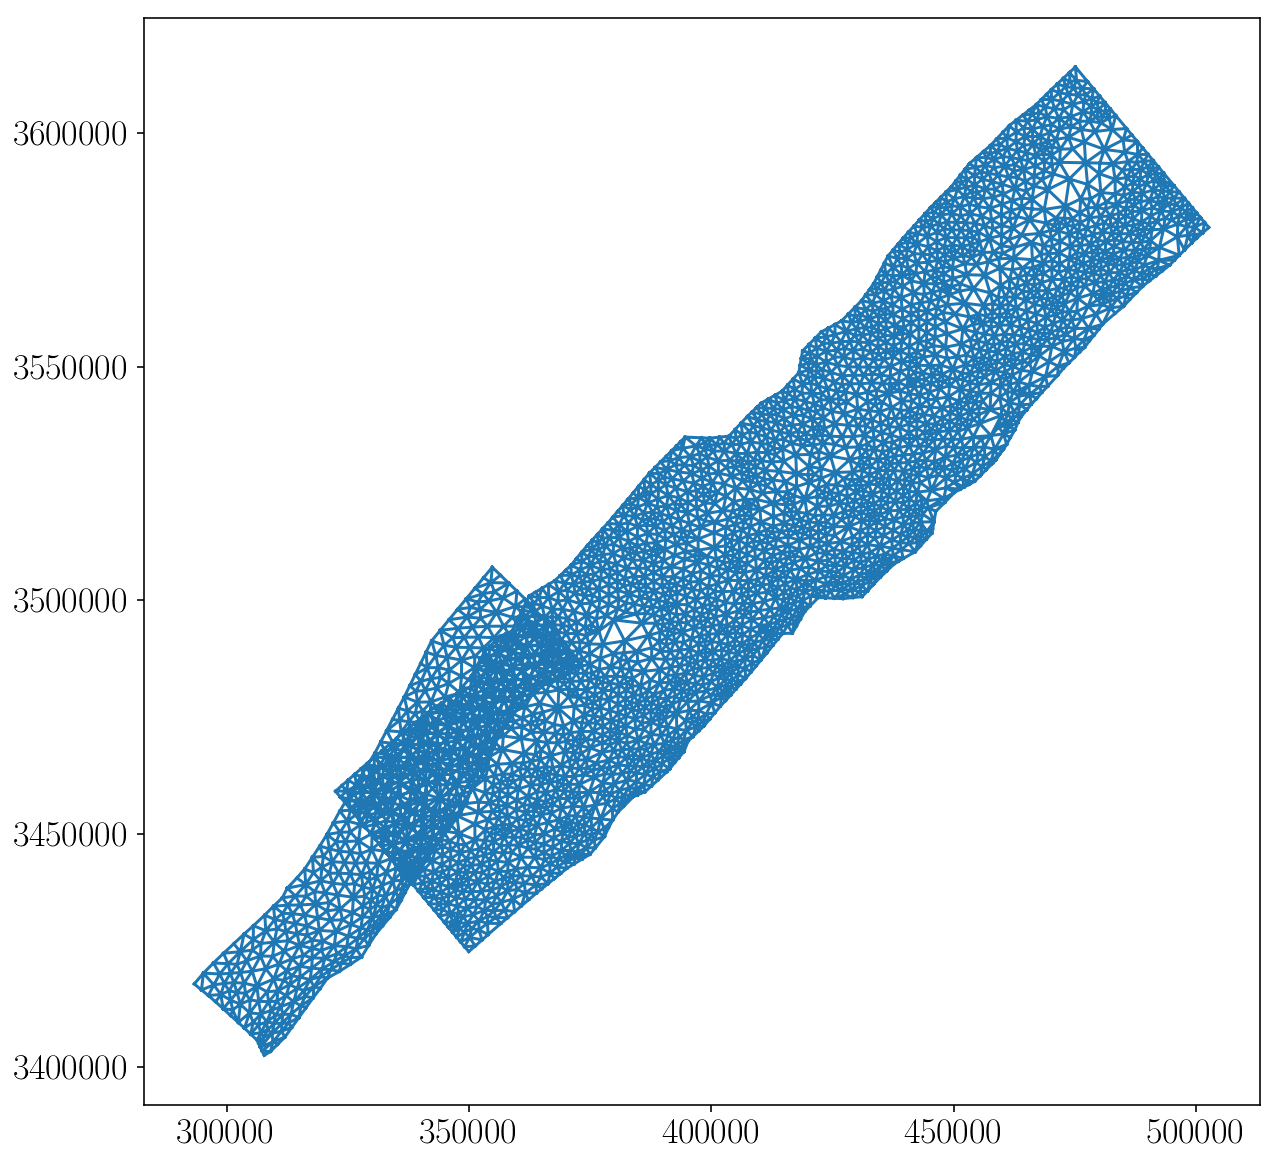

In [25]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [11]:
import meshio
meshio.write('/tmp/dense_fault.msh', fault_m[0], {'triangle': fault_m[1]})

In [12]:
code = """
Merge "dense_fault.msh";
RefineMesh;
CreateTopology;

ll[] = Line "*";
For j In {0 : #ll[]-1}
  Compound Line(newl) = ll[j];
EndFor
ss[] = Surface "*";
s = news;
For i In {0 : #ss[]-1}
  Compound Surface(s+i) = ss[i];
EndFor

Field[1] = MathEval;
Field[1].F = "10000.0";
Background Field = 1;

Mesh.RemeshAlgorithm = 1;
Mesh.RemeshParametrization = 7;
Geometry.HideCompounds = 1;
"""
import pygmsh
geom = pygmsh.built_in.Geometry()
geom.add_raw_code(code)
simplify_pts, simplify_cells, point_data, cell_data, field_data = pygmsh.generate_mesh(geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0)

Info    : Running 'gmsh -2 -bin /tmp/tmpwru2wsl9.geo -o /tmp/tmplpjzszij.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Fri Oct 20 16:51:07 2017
Info    : Reading '/tmp/tmpwru2wsl9.geo'...
Info    : Reading '/tmp/dense_fault.msh'...
Info    : 3575 vertices
Info    : 6732 elements
Info    : Done reading '/tmp/dense_fault.msh'
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : Meshing surface 0 order 2
Info    : Finalized high order topology of periodic connections
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.104272
Info    : Done meshing order 2 (0.018785 s)
Info    : Done refining mesh (0.031026 s)
Info    : Creating topology from mesh...
Info    : Removing duplicate mesh vertices...
Info    : Found 0 duplicate vertices 
Info    : No duplicate vertices found
Info    : Creating the geometry of discrete curves
Info    : Done creating topology from mesh (0.19339 s)
Info    : Done reading '/tmp/tmpwru2

In [157]:
simplify_tris = simplify_cells['triangle'][cell_data['triangle']['geometrical'] > 2]
fault_m = remove_unused_pts((simplify_pts, simplify_tris))
fault_m[0].shape[0], fault_m[1].shape[0]

(237, 386)

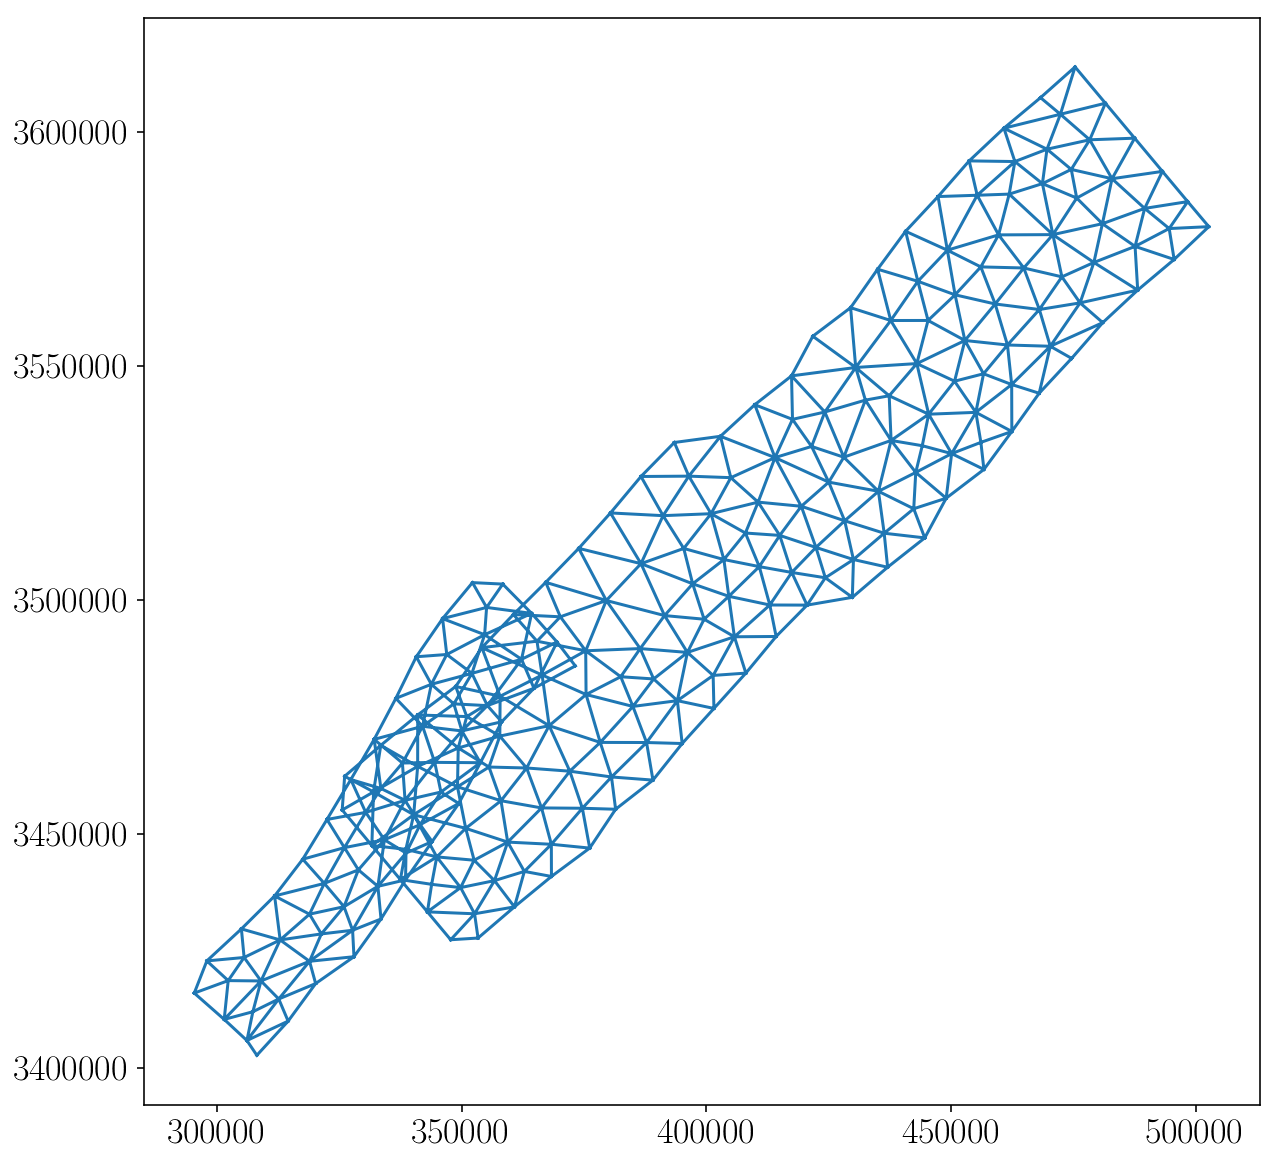

In [158]:
plt.figure(figsize = (10,10))
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.show()

In [170]:
orderings = get_boundary_loop(fault_m)

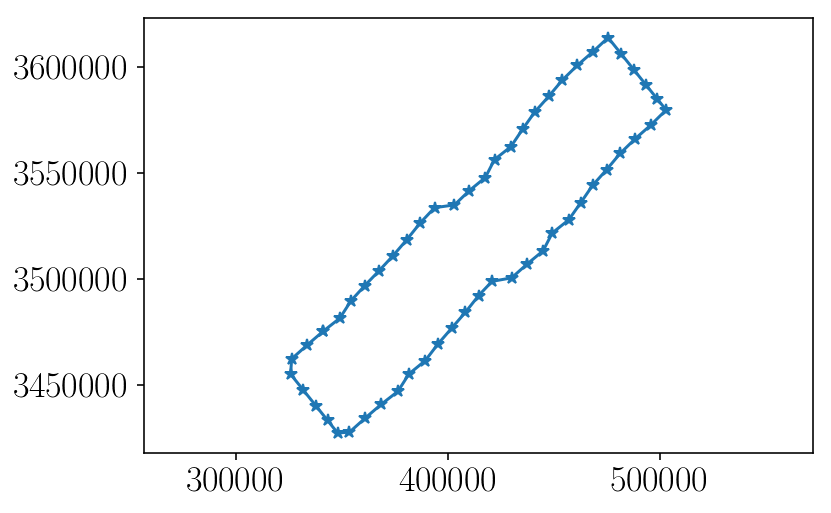

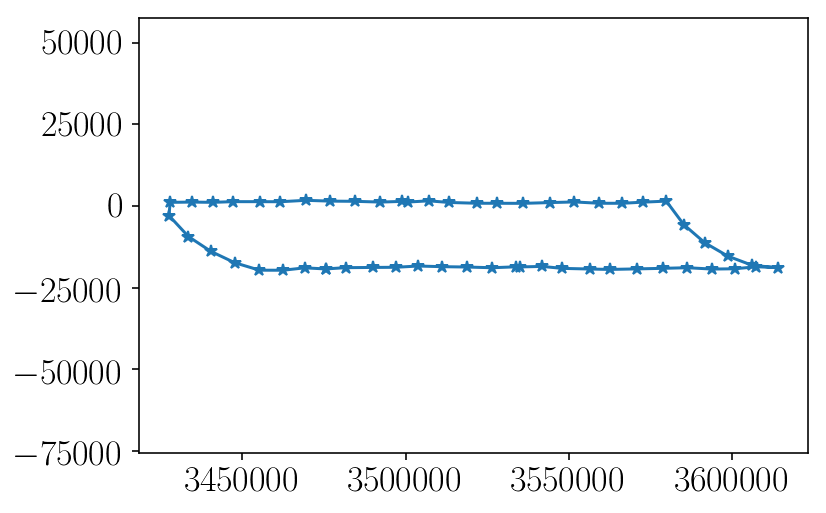

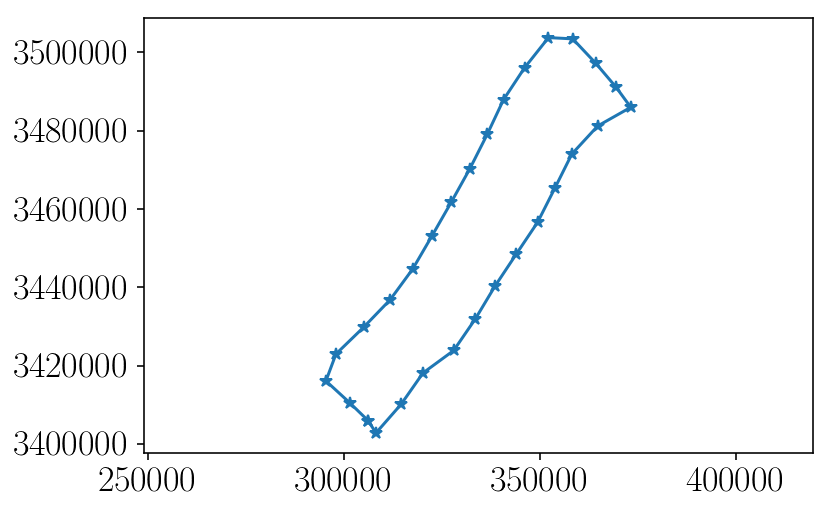

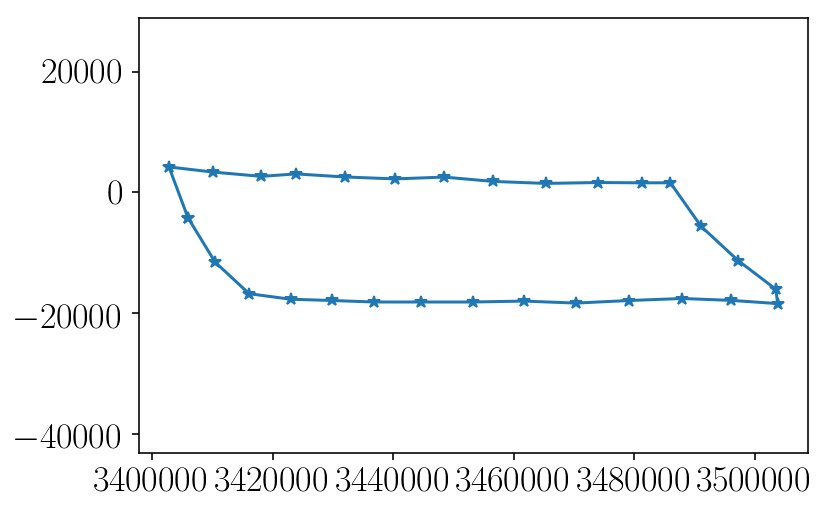

In [171]:
for i in range(len(orderings)):
    ordering = orderings[i]
    plt.figure()
    plt.plot(fault_m[0][ordering, 0], fault_m[0][ordering, 1], '-*')
    plt.axis('equal')
    plt.figure()
    plt.plot(fault_m[0][ordering, 1], fault_m[0][ordering, 2], '-*')
    plt.axis('equal')
    plt.show()

In [133]:
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

5 24 12
5 25 12
5 24 13
5 25 13


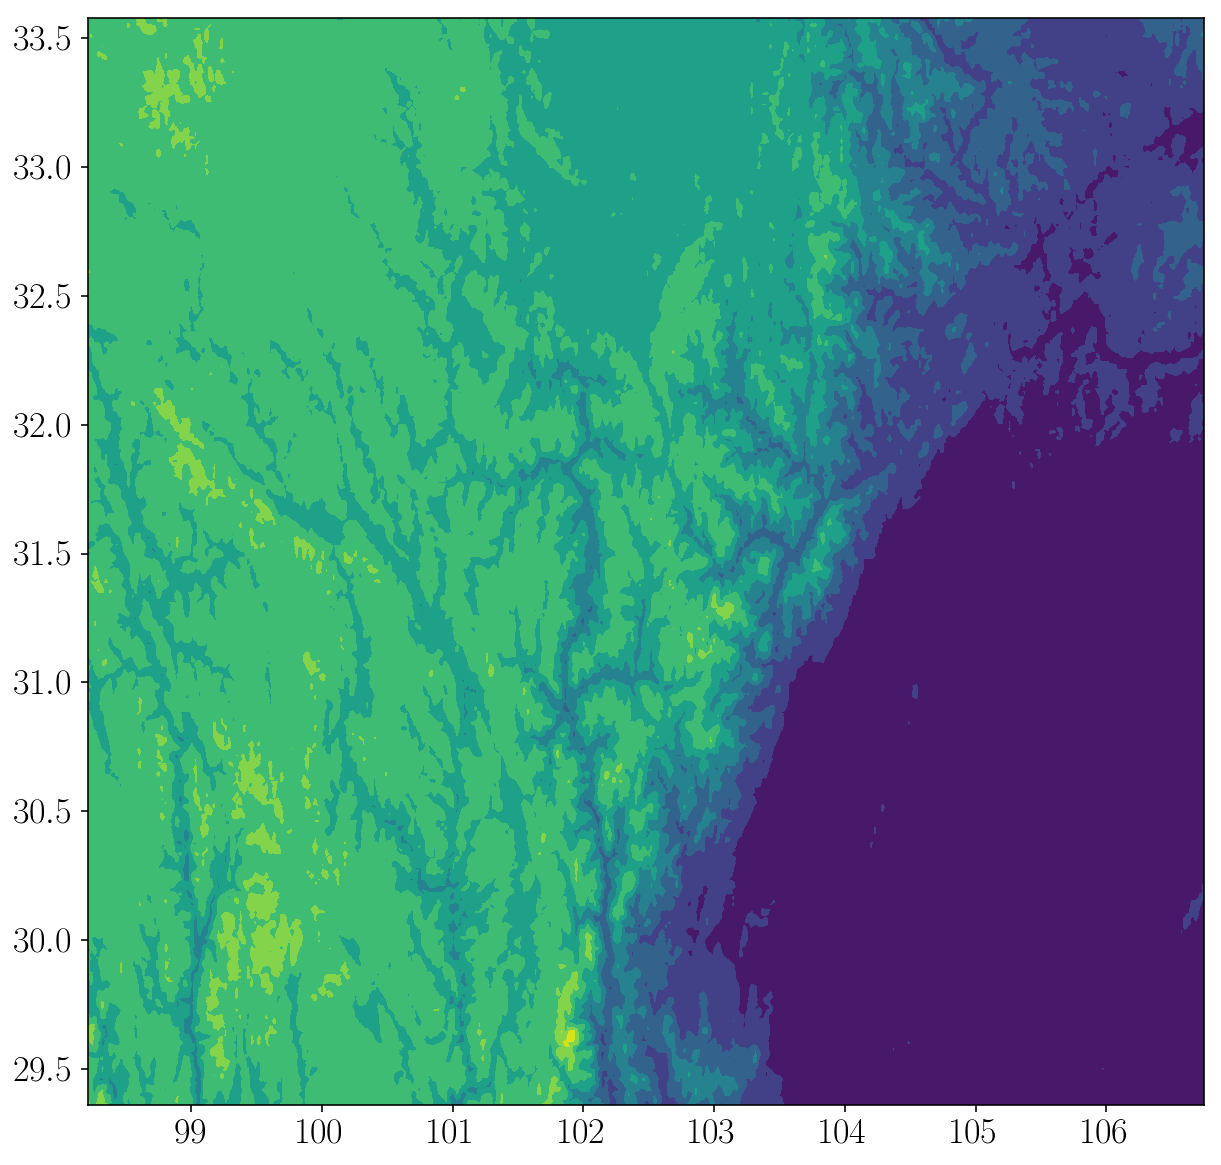

In [134]:
plt.figure(figsize = (10,10))
plt.tricontourf(LON, LAT, DEM)
plt.show()

In [114]:
proj_dem = collect_dem.project(LON, LAT, DEM, proj)

48R


In [329]:
fault_pt_elevations = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (fault_m[0][:,0], fault_m[0][:,1])
)

In [330]:
vertical_diff = fault_pt_elevations - fault_m[0][:,2]
below_surf = np.abs(vertical_diff) >= 800
above_surf = np.logical_not(below_surf)

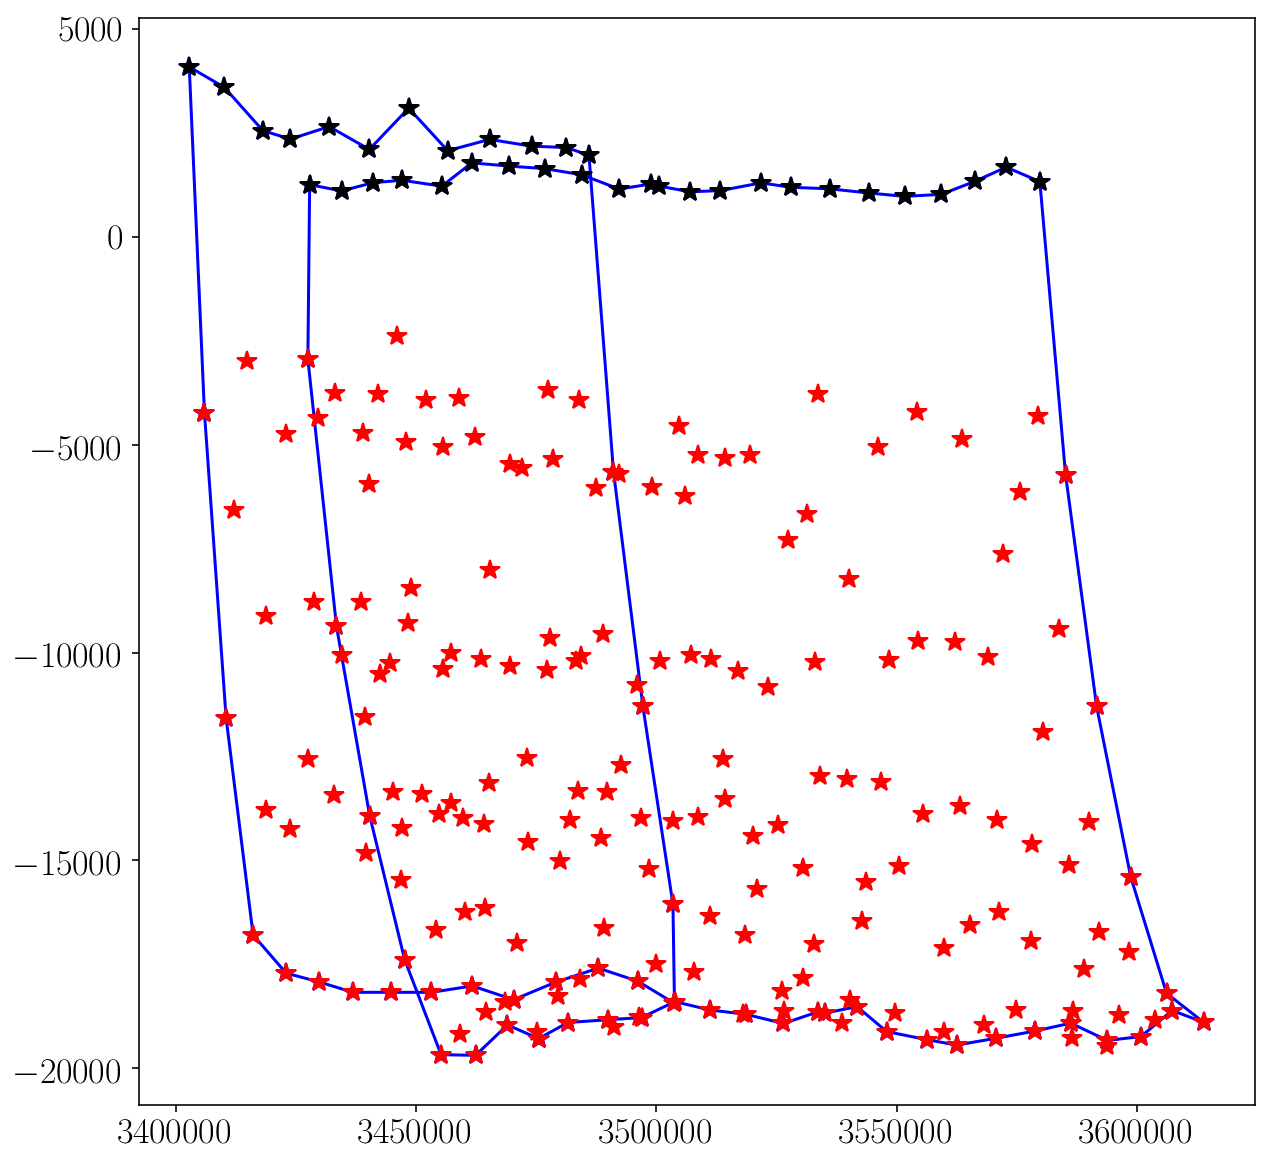

In [331]:
plt.figure(figsize = (10, 10))
for i in range(len(orderings)):
    plt.plot(fault_m[0][orderings[i], 1], fault_m[0][orderings[i], 2], 'b-*', markersize = 10)
plt.plot(fault_m[0][above_surf, 1], fault_pt_elevations[above_surf], 'k*', markersize = 10)
plt.plot(fault_m[0][below_surf, 1], fault_m[0][below_surf, 2], 'r*', markersize = 10, zorder = 10)
plt.show()

In [187]:
surface_fault_edges = []
for fault_edge in orderings:
    for i in range(len(fault_edge) - 1):
        vertex1 = fault_edge[i]
        vertex2 = fault_edge[i + 1]
        if below_surf[vertex1] or below_surf[vertex2]:
            continue
        surface_fault_edges.append((vertex1, vertex2))
surface_fault_edges = np.array(surface_fault_edges)

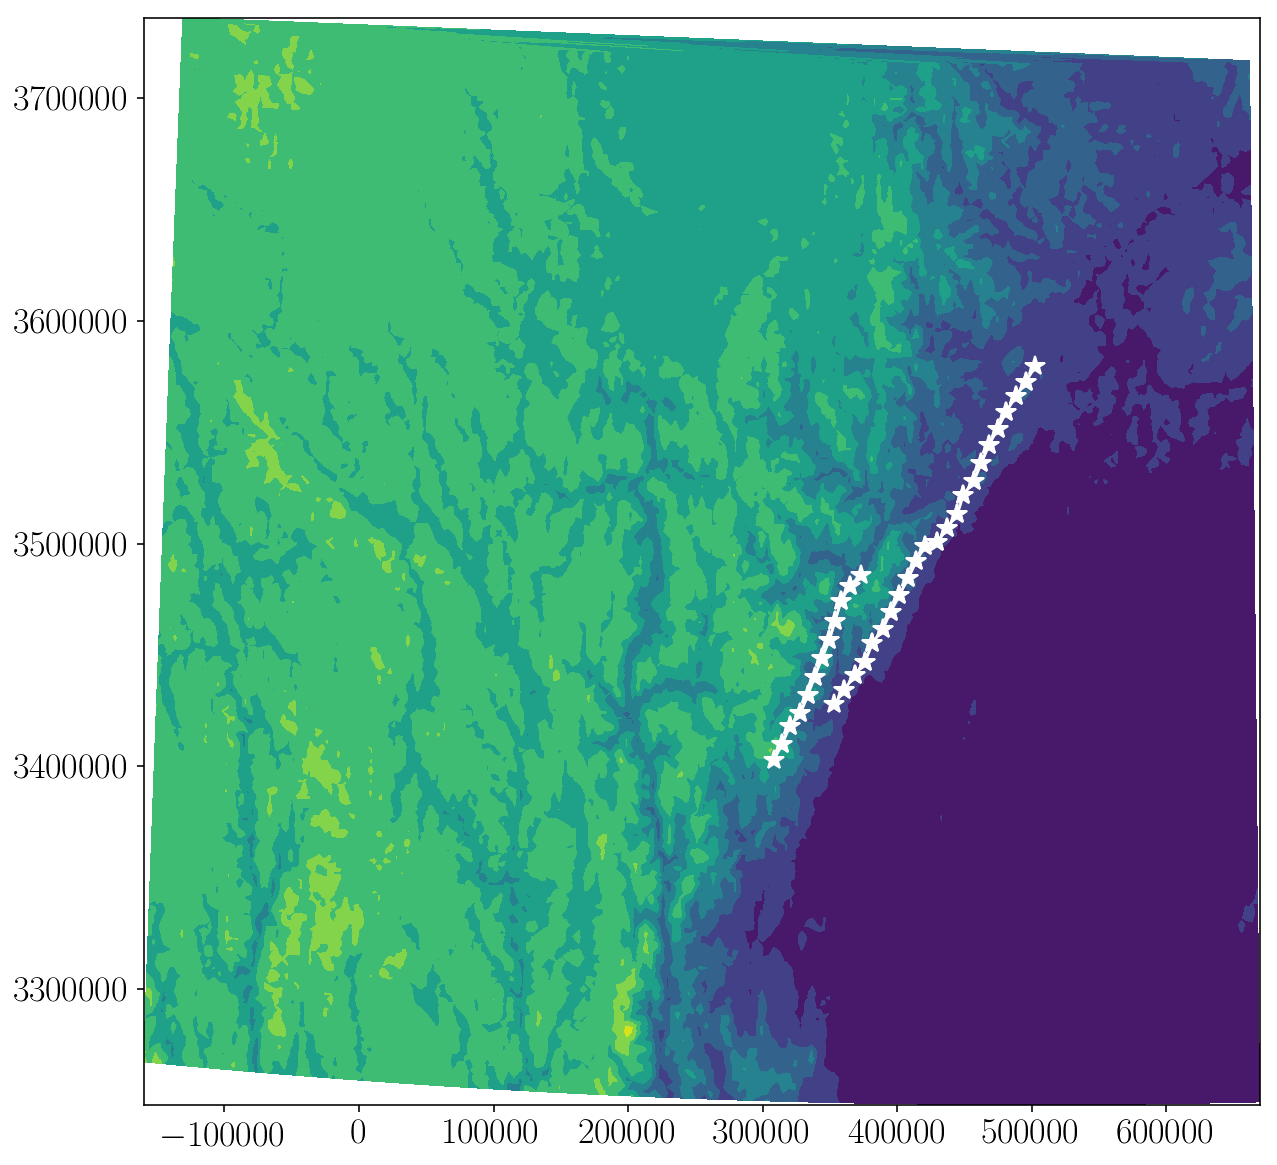

In [188]:
plt.figure(figsize = (10,10))
plt.tricontourf(proj_dem[:,0], proj_dem[:,1], proj_dem[:,2])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'w-*', markersize = 10)
plt.show()

In [271]:
upper_edge_idxs = np.unique(surface_fault_edges)
upper_edge_pts = fault_m[0][upper_edge_idxs,:]
upper_edge_pts.shape

(35, 3)

In [324]:
surf_center = np.mean(upper_edge_pts, axis = 0)
fault_L = np.max(np.sqrt(np.sum((upper_edge_pts - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 10
surf_center, fault_L

(array([  3.98409151e+05,   3.48312593e+06,   1.60278421e+03]),
 142192.37157032787)

In [325]:
geom = pygmsh.built_in.Geometry()

w = fault_L * 4
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
for edge in surface_fault_edges:
    for j in range(2):
        if edge[j] not in gmsh_pts:
            gmsh_pts[edge[j]] = geom.add_point(fault_m[0][edge[j]], mesh_size)
    line = geom.add_line(gmsh_pts[edge[0]], gmsh_pts[edge[1]])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

In [326]:
points, cells, pt_data, cell_data, field_data = pygmsh.generate_mesh(
    geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0
)

Info    : Running 'gmsh -2 -bin /tmp/tmpu11z08f7.geo -o /tmp/tmphw1eakfn.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Fri Oct 20 21:27:32 2017
Info    : Reading '/tmp/tmpu11z08f7.geo'...
Info    : Done reading '/tmp/tmpu11z08f7.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve

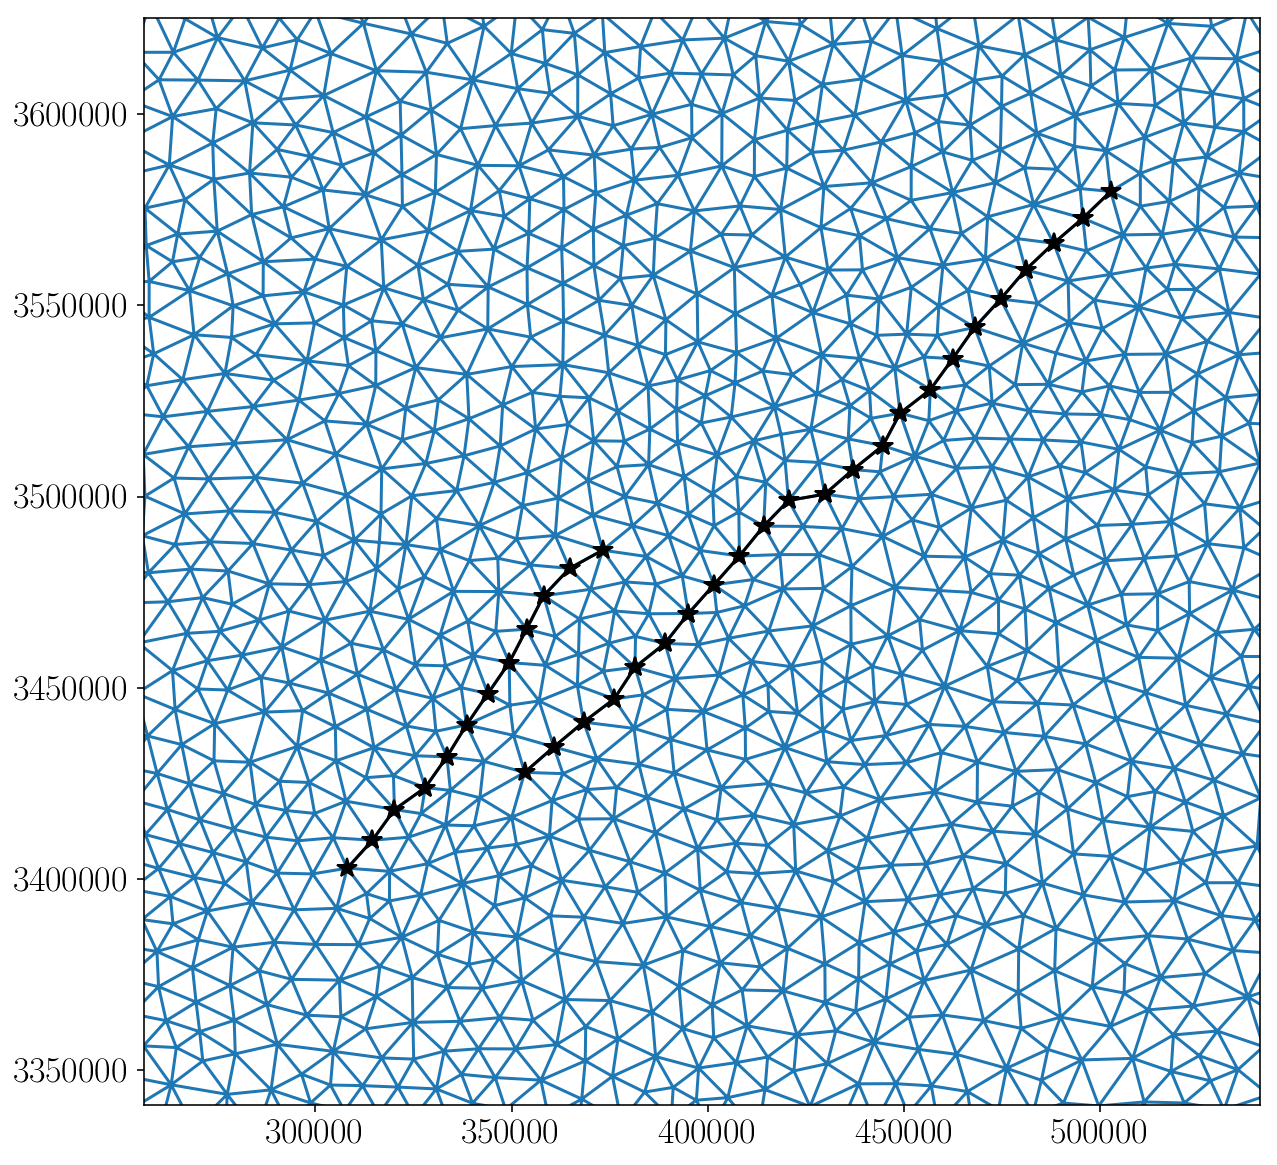

In [327]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'])
for edge in surface_fault_edges:
    pts = fault_m[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'k-*', markersize = 10)
vW = 1 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

In [312]:
lonlat_pts = collect_dem.project(points[:,0], points[:,1], points[:,2], proj, inverse = True)
bounds = get_dem_bounds(lonlat_pts)
bounds

48R


(25.150509907854026,
 96.264352348334782,
 37.654578082684466,
 111.48261354726965)

In [313]:
proj_dem = collect_dem.project(*collect_dem.get_dem(zoom, bounds, n_dem_interp_pts), proj)

5 24 12
5 25 12
5 24 13
5 25 13
48R


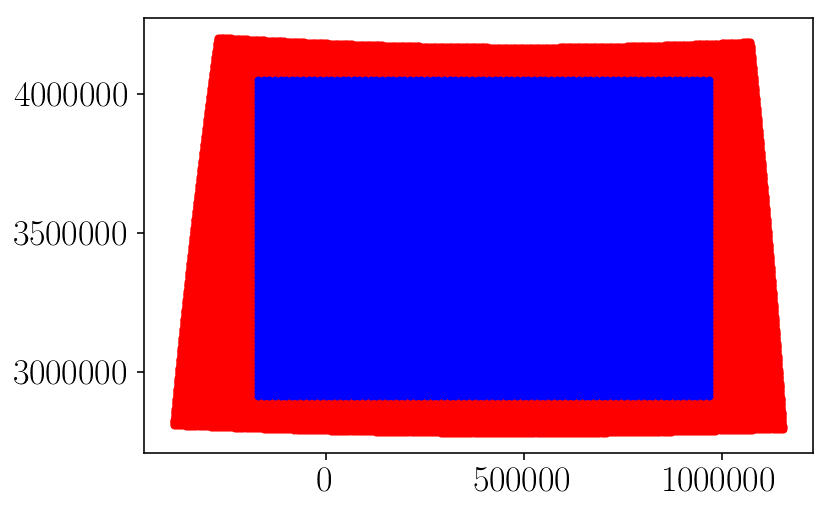

In [314]:
plt.plot(proj_dem[:,0], proj_dem[:,1], 'r.')
plt.plot(points[:,0], points[:,1], 'b.')
plt.show()

In [350]:
flat_surf_m = (points, cells['triangle'])

In [414]:
from tectosaur.mesh.refine import refine as core_refine

def refine(m, n):
    if n == 0:
        return m
    elif n == 1:
        return core_refine(m)
    else:
        return refine(core_refine(m), n - 1)

refinements = 1
refined_flat_surf_m = refine(flat_surf_m, refinements)
refined_fault_m = refine(fault_m, refinements)
refined_fault_pt_elevations = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_fault_m[0][:,0], refined_fault_m[0][:,1])
)
refined_vertical_diff = refined_fault_pt_elevations - refined_fault_m[0][:,2]
refined_below_surf = np.abs(refined_vertical_diff) >= 800
refined_above_surf = np.logical_not(refined_below_surf)

In [415]:
refined_flat_surf_m[0][:,2] = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_flat_surf_m[0][:,0], refined_flat_surf_m[0][:,1])
)
refined_fault_m[0][refined_above_surf,2] = scipy.interpolate.griddata(
    (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
    (refined_fault_m[0][refined_above_surf,0], refined_fault_m[0][refined_above_surf,1])
)

In [416]:
from tectosaur.mesh.modify import concat
full_m = concat(refined_flat_surf_m, refined_fault_m)
full_m[0][:,2] *= 5
np.save('mesh.npy', full_m)

In [417]:
full_m[1].shape[0]

86392

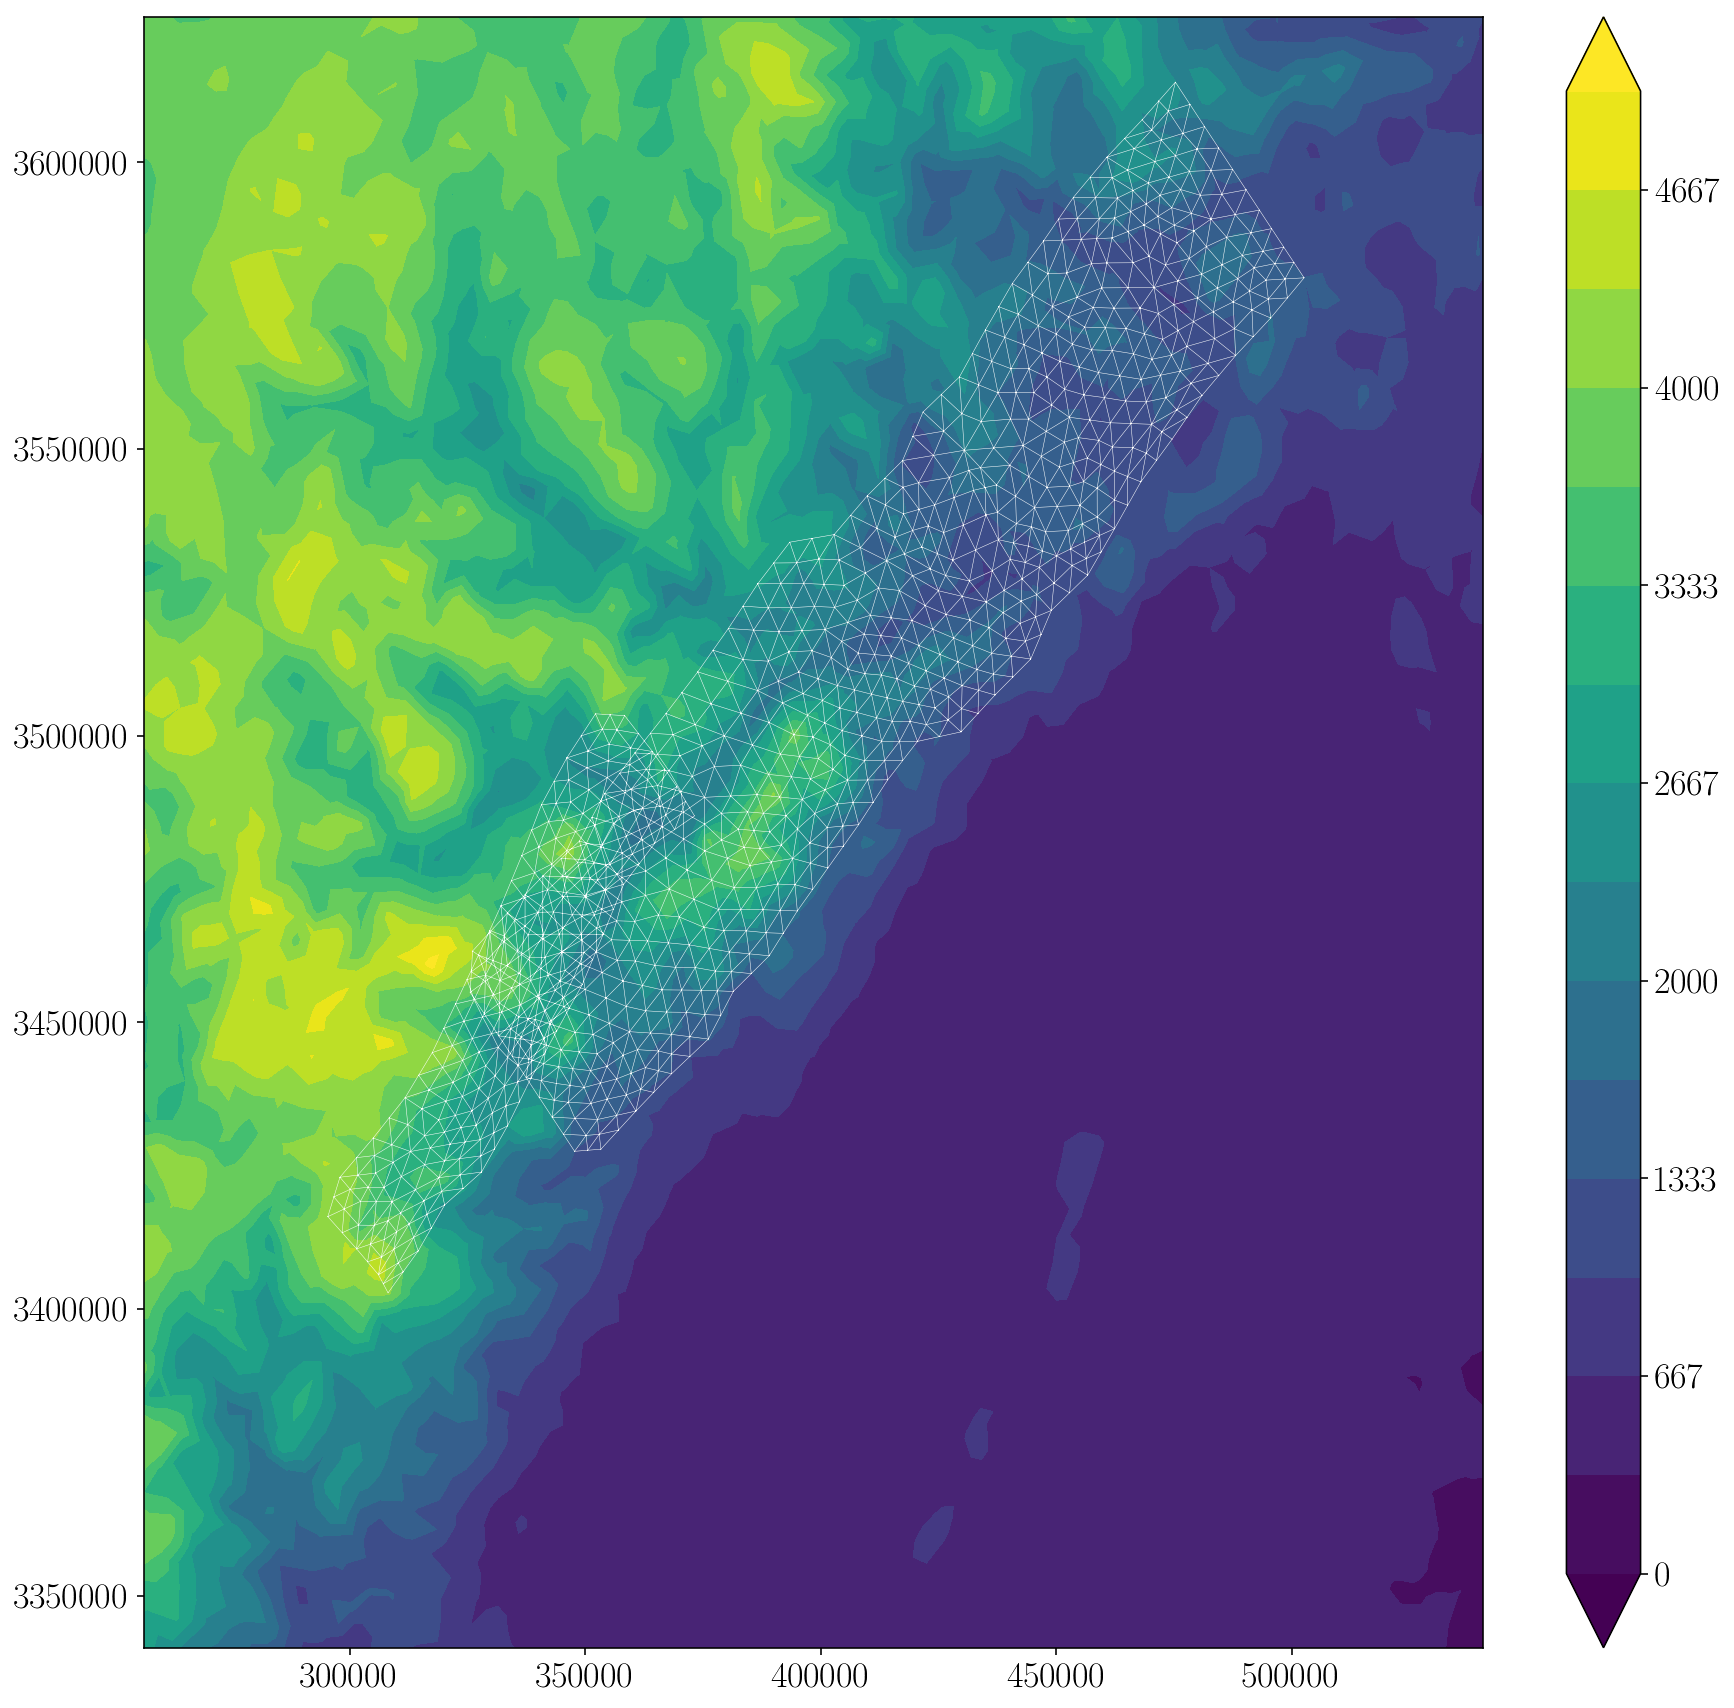

In [418]:
plt.figure(figsize = (15,15))
cntf = plt.tricontourf(refined_flat_surf_m[0][:,0], refined_flat_surf_m[0][:,1], refined_flat_surf_m[1], refined_flat_surf_m[0][:,2], levels = np.linspace(0, 5000, 16), extend = 'both')
plt.triplot(refined_fault_m[0][:,0], refined_fault_m[0][:,1], refined_fault_m[1], 'w-', linewidth = 0.25)
vW = 1 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.colorbar()
plt.show()

In [455]:
np.save('forward_model_meshes.npy', [refined_flat_surf_m, refined_fault_m])

In [3]:
refined_flat_surf_m, refined_fault_m = np.load('forward_model_meshes.npy')

In [5]:
import tectosaur_topo as tt
sm = 1.0
pr = 0.25
slip = np.array([[1, 0, 0] * refined_fault_m[1].size]).flatten()
m_pts, m_tris, fault_start_idx, soln = tt.solve_topo(refined_flat_surf_m, refined_fault_m, slip, sm, pr)

2017-10-22 22:20:13,023 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-10-22 22:20:13,028 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.005208253860473633
2017-10-22 22:20:13,036 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.007078886032104492
2017-10-22 22:20:13,225 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.18807220458984375
2017-10-22 22:20:13,227 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-10-22 22:20:13,286 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.059616804122924805
2017-10-22 22:20:13,410 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.12293457984924316
2017-10-22 22:20:13,454 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.42447352409362793
2017-10-22 22:20:13,472 - tectosaur.nearfield.nearfield_op - DEBUG -     Co

2017-10-22 22:20:35,938 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.010131359100341797
2017-10-22 22:20:35,939 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5334656238555908
2017-10-22 22:20:35,947 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.007085084915161133
2017-10-22 22:20:35,948 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5505092144012451
2017-10-22 22:20:36,391 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43039917945861816
2017-10-22 22:20:36,400 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007052421569824219
2017-10-22 22:20:36,416 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.014837265014648438
2017-10-22 22:20:36,925 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5073575973510742
2017-10-22 22:20:36,927 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5098023414611816
2017-10-22 22

2017-10-22 22:20:43,336 - tectosaur_topo.solve - DEBUG - residual: 0.11289985053307425
2017-10-22 22:20:43,338 - tectosaur_topo.solve - DEBUG - 6
2017-10-22 22:20:43,774 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43203186988830566
2017-10-22 22:20:43,783 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007390737533569336
2017-10-22 22:20:43,796 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.012033462524414062
2017-10-22 22:20:44,303 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5052993297576904
2017-10-22 22:20:44,304 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5072674751281738
2017-10-22 22:20:44,314 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.008469820022583008
2017-10-22 22:20:44,315 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5307683944702148
2017-10-22 22:20:44,325 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot

2017-10-22 22:20:51,375 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5125470161437988
2017-10-22 22:20:51,390 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.01386260986328125
2017-10-22 22:20:51,391 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5412847995758057
2017-10-22 22:20:51,401 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.009705543518066406
2017-10-22 22:20:51,402 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5616989135742188
2017-10-22 22:20:51,417 - tectosaur_topo.solve - DEBUG - iteration # 9 took 2.0452322959899902
2017-10-22 22:20:51,418 - tectosaur_topo.solve - DEBUG - residual: 0.023378887646729848
2017-10-22 22:20:51,421 - tectosaur_topo.solve - DEBUG - 10
2017-10-22 22:20:51,866 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43979859352111816
2017-10-22 22:20:51,875 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0

2017-10-22 22:20:58,447 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.006825685501098633
2017-10-22 22:20:58,448 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5461373329162598
2017-10-22 22:20:58,891 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43030810356140137
2017-10-22 22:20:58,900 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007536649703979492
2017-10-22 22:20:58,913 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011917591094970703
2017-10-22 22:20:59,418 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5035734176635742
2017-10-22 22:20:59,419 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5055289268493652
2017-10-22 22:20:59,428 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.007651090621948242
2017-10-22 22:20:59,429 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5281336307525635
2017-10-22 22

2017-10-22 22:21:05,941 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0073773860931396484
2017-10-22 22:21:05,954 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.012030839920043945
2017-10-22 22:21:06,465 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5081787109375
2017-10-22 22:21:06,466 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5103137493133545
2017-10-22 22:21:06,477 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.009836912155151367
2017-10-22 22:21:06,478 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5351424217224121
2017-10-22 22:21:06,486 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.007312774658203125
2017-10-22 22:21:06,487 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.55312180519104
2017-10-22 22:21:06,930 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43129825592041016
2017-10-22 22:21:

2017-10-22 22:21:13,469 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0068018436431884766
2017-10-22 22:21:13,470 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5499427318572998
2017-10-22 22:21:13,481 - tectosaur_topo.solve - DEBUG - iteration # 20 took 1.977773904800415
2017-10-22 22:21:13,483 - tectosaur_topo.solve - DEBUG - residual: 0.0017896593058526913
2017-10-22 22:21:13,488 - tectosaur_topo.solve - DEBUG - 21
2017-10-22 22:21:13,913 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4203650951385498
2017-10-22 22:21:13,921 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007122039794921875
2017-10-22 22:21:13,934 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011685371398925781
2017-10-22 22:21:14,445 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5089492797851562
2017-10-22 22:21:14,446 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.510799

2017-10-22 22:21:20,875 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00734710693359375
2017-10-22 22:21:20,891 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.014589786529541016
2017-10-22 22:21:21,398 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5055761337280273
2017-10-22 22:21:21,399 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5074934959411621
2017-10-22 22:21:21,408 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.007478237152099609
2017-10-22 22:21:21,409 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5325863361358643
2017-10-22 22:21:21,418 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.008811235427856445
2017-10-22 22:21:21,419 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5518503189086914
2017-10-22 22:21:21,434 - tectosaur_topo.solve - DEBUG - iteration # 24 took 1.9906811714172363
2017-10-22 22:21:21,435 - 

2017-10-22 22:21:28,324 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5079686641693115
2017-10-22 22:21:28,334 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.008849620819091797
2017-10-22 22:21:28,335 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5320959091186523
2017-10-22 22:21:28,346 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.010090112686157227
2017-10-22 22:21:28,347 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5527260303497314
2017-10-22 22:21:28,800 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.43723320960998535
2017-10-22 22:21:28,809 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007292985916137695
2017-10-22 22:21:28,822 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011577367782592773
2017-10-22 22:21:29,328 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5041866302490234
2017-10-22 22

2017-10-22 22:21:35,376 - tectosaur_topo.solve - DEBUG - residual: 0.00016750440633931185
2017-10-22 22:21:35,384 - tectosaur_topo.solve - DEBUG - 32
2017-10-22 22:21:35,834 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.44381070137023926
2017-10-22 22:21:35,843 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007324695587158203
2017-10-22 22:21:35,859 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.014859437942504883
2017-10-22 22:21:36,365 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5048747062683105
2017-10-22 22:21:36,366 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5068492889404297
2017-10-22 22:21:36,375 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.007930278778076172
2017-10-22 22:21:36,376 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.532623291015625
2017-10-22 22:21:36,386 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.

2017-10-22 22:21:43,346 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5093865394592285
2017-10-22 22:21:43,353 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00597691535949707
2017-10-22 22:21:43,354 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5301744937896729
2017-10-22 22:21:43,362 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.006916046142578125
2017-10-22 22:21:43,363 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5477449893951416
2017-10-22 22:21:43,374 - tectosaur_topo.solve - DEBUG - iteration # 35 took 1.9673972129821777
2017-10-22 22:21:43,375 - tectosaur_topo.solve - DEBUG - residual: 7.756302793722875e-05
2017-10-22 22:21:43,384 - tectosaur_topo.solve - DEBUG - 36
2017-10-22 22:21:43,812 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4230482578277588
2017-10-22 22:21:43,821 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.

2017-10-22 22:21:52,072 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5804610252380371
2017-10-22 22:21:52,849 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.7544286251068115
2017-10-22 22:21:52,869 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.01889324188232422
2017-10-22 22:21:52,894 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.023675203323364258
2017-10-22 22:21:53,408 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5115487575531006
2017-10-22 22:21:53,410 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5148851871490479
2017-10-22 22:21:53,437 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.025537729263305664
2017-10-22 22:21:53,438 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5670859813690186
2017-10-22 22:21:53,457 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.018725156784057617
2017-10-22 22:2

2017-10-22 22:22:02,302 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.015027523040771484
2017-10-22 22:22:02,811 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5060708522796631
2017-10-22 22:22:02,812 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.50872802734375
2017-10-22 22:22:02,834 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.020633459091186523
2017-10-22 22:22:02,835 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5476341247558594
2017-10-22 22:22:02,848 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.012192726135253906
2017-10-22 22:22:02,849 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.57568359375
2017-10-22 22:22:03,435 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.5667228698730469
2017-10-22 22:22:03,450 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.013283252716064453
2017-10-22 22:22:03,4

2017-10-22 22:22:12,513 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5802915096282959
2017-10-22 22:22:12,542 - tectosaur_topo.solve - DEBUG - iteration # 46 took 2.8036386966705322
2017-10-22 22:22:12,544 - tectosaur_topo.solve - DEBUG - residual: 9.517509146929065e-06
2017-10-22 22:22:12,562 - tectosaur_topo.solve - DEBUG - 47
2017-10-22 22:22:13,361 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.7857122421264648
2017-10-22 22:22:13,379 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.015990257263183594
2017-10-22 22:22:13,403 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.022940635681152344
2017-10-22 22:22:13,917 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5111415386199951
2017-10-22 22:22:13,919 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5144898891448975
2017-10-22 22:22:13,944 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.024458646774291992

2017-10-22 22:22:21,568 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.014924287796020508
2017-10-22 22:22:22,077 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5074656009674072
2017-10-22 22:22:22,080 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5117342472076416
2017-10-22 22:22:22,089 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0072629451751708984
2017-10-22 22:22:22,090 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5376105308532715
2017-10-22 22:22:22,098 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.006913185119628906
2017-10-22 22:22:22,099 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5567963123321533
2017-10-22 22:22:22,111 - tectosaur_topo.solve - DEBUG - iteration # 50 took 2.1274454593658447
2017-10-22 22:22:22,112 - tectosaur_topo.solve - DEBUG - residual: 4.7632915114923845e-06
2017-10-22 22:22:22,125 - tectosaur_topo.solve - DEBU

2017-10-22 22:22:29,172 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.006325721740722656
2017-10-22 22:22:29,173 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5293946266174316
2017-10-22 22:22:29,181 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00666499137878418
2017-10-22 22:22:29,182 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5463993549346924
2017-10-22 22:22:29,613 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4199070930480957
2017-10-22 22:22:29,622 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00728917121887207
2017-10-22 22:22:29,635 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011435985565185547
2017-10-22 22:22:30,144 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5078856945037842
2017-10-22 22:22:30,145 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5097708702087402
2017-10-22 22:22

2017-10-22 22:22:36,271 - tectosaur_topo.solve - DEBUG - 58
2017-10-22 22:22:36,698 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4216041564941406
2017-10-22 22:22:36,708 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.008434772491455078
2017-10-22 22:22:36,720 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011381864547729492
2017-10-22 22:22:37,227 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5050556659698486
2017-10-22 22:22:37,228 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5069906711578369
2017-10-22 22:22:37,235 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.006155490875244141
2017-10-22 22:22:37,236 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.527534008026123
2017-10-22 22:22:37,244 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0065801143646240234
2017-10-22 22:22:37,245 - tectosaur.ops.sparse_integral_op -

2017-10-22 22:22:44,328 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.007638454437255859
2017-10-22 22:22:44,329 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5304930210113525
2017-10-22 22:22:44,339 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.008818626403808594
2017-10-22 22:22:44,340 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5502398014068604
2017-10-22 22:22:44,354 - tectosaur_topo.solve - DEBUG - iteration # 61 took 2.0117459297180176
2017-10-22 22:22:44,356 - tectosaur_topo.solve - DEBUG - residual: 6.843352126111171e-07
2017-10-22 22:22:44,371 - tectosaur_topo.solve - DEBUG - 62
2017-10-22 22:22:44,808 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4309659004211426
2017-10-22 22:22:44,819 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00904393196105957
2017-10-22 22:22:44,835 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space 

2017-10-22 22:22:51,400 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5454459190368652
2017-10-22 22:22:51,832 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4203197956085205
2017-10-22 22:22:51,841 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0075190067291259766
2017-10-22 22:22:51,854 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011901378631591797
2017-10-22 22:22:52,362 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5060451030731201
2017-10-22 22:22:52,363 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5078861713409424
2017-10-22 22:22:52,372 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0074214935302734375
2017-10-22 22:22:52,373 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5302605628967285
2017-10-22 22:22:52,382 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.008638143539428711
2017-10-22 2

2017-10-22 22:22:58,856 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011966228485107422
2017-10-22 22:22:59,364 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5062477588653564
2017-10-22 22:22:59,365 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5081832408905029
2017-10-22 22:22:59,372 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.006209373474121094
2017-10-22 22:22:59,373 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5294153690338135
2017-10-22 22:22:59,381 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.006581306457519531
2017-10-22 22:22:59,382 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5464379787445068
2017-10-22 22:22:59,823 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4297056198120117
2017-10-22 22:22:59,832 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0075969696044921875
2017-10-22 22

2017-10-22 22:23:06,373 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.543895959854126
2017-10-22 22:23:06,385 - tectosaur_topo.solve - DEBUG - iteration # 72 took 1.9711451530456543
2017-10-22 22:23:06,386 - tectosaur_topo.solve - DEBUG - residual: 7.660279022813915e-08
2017-10-22 22:23:06,404 - tectosaur_topo.solve - DEBUG - 73
2017-10-22 22:23:06,827 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.41884589195251465
2017-10-22 22:23:06,836 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007241964340209961
2017-10-22 22:23:06,849 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011977434158325195
2017-10-22 22:23:07,356 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.504706859588623
2017-10-22 22:23:07,357 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5067305564880371
2017-10-22 22:23:07,365 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.006566286087036133


2017-10-22 22:23:13,883 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.011425256729125977
2017-10-22 22:23:14,398 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.5138912200927734
2017-10-22 22:23:14,400 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5157709121704102
2017-10-22 22:23:14,408 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.007327079772949219
2017-10-22 22:23:14,409 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.5375237464904785
2017-10-22 22:23:14,418 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.008602619171142578
2017-10-22 22:23:14,419 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5565683841705322
2017-10-22 22:23:14,434 - tectosaur_topo.solve - DEBUG - iteration # 76 took 1.9722003936767578
2017-10-22 22:23:14,435 - tectosaur_topo.solve - DEBUG - residual: 3.519511274130605e-08
2017-10-22 22:23:14,453 - tectosaur_topo.solve - DEBUG 

2017-10-22 22:23:21,383 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.005922794342041016
2017-10-22 22:23:21,385 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.530238151550293
2017-10-22 22:23:21,392 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0067403316497802734
2017-10-22 22:23:21,393 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.5474894046783447
2017-10-22 22:23:21,826 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.4206578731536865
2017-10-22 22:23:21,835 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.007349491119384766
2017-10-22 22:23:21,847 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.01141810417175293
2017-10-22 22:23:22,353 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.504328727722168
2017-10-22 22:23:22,354 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.5061793327331543
2017-10-22 22:23

In [26]:
surf_tris = m_tris[:fault_start_idx]
fault_tris = m_tris[fault_start_idx:]

In [140]:
connectivity = tri_connectivity_graph(m_tris)
fault_touching_pair = np.where(np.logical_and(
    connectivity.row < fault_start_idx, 
    connectivity.col >= fault_start_idx
))[0]

In [241]:
from tectosaur.util.geometry import unscaled_normals

side = np.zeros(m_tris.shape[0])
shared_verts = np.zeros(m_tris.shape[0])

fault_surf_tris = m_pts[m_tris[connectivity.col[fault_touching_pair]]]
normals = unscaled_normals(fault_surf_tris)
normals /= np.linalg.norm(normals, axis = 1)[:,np.newaxis]
for i in range(fault_touching_pair.shape[0]):
    surf_tri_idx = connectivity.row[fault_touching_pair[i]]
    surf_tri = m_tris[surf_tri_idx]
    fault_tri = m_tris[connectivity.col[fault_touching_pair[i]]]
    
    surf_tri_center = np.mean(m_pts[surf_tri], axis = 0)
    fault_tri_center = np.mean(m_pts[fault_tri], axis = 0)
    direction = surf_tri_center - fault_tri_center
    direction /= np.linalg.norm(direction)
    
    n_shared_verts = 0
    for d in range(3):
        if surf_tri[d] in fault_tri:
            n_shared_verts += 1
    
    which_way = direction.dot(normals[i,:]) > 0
    if shared_verts[surf_tri_idx] < 2:
        side[surf_tri_idx] = int(which_way) + 1
        shared_verts[surf_tri_idx] = n_shared_verts

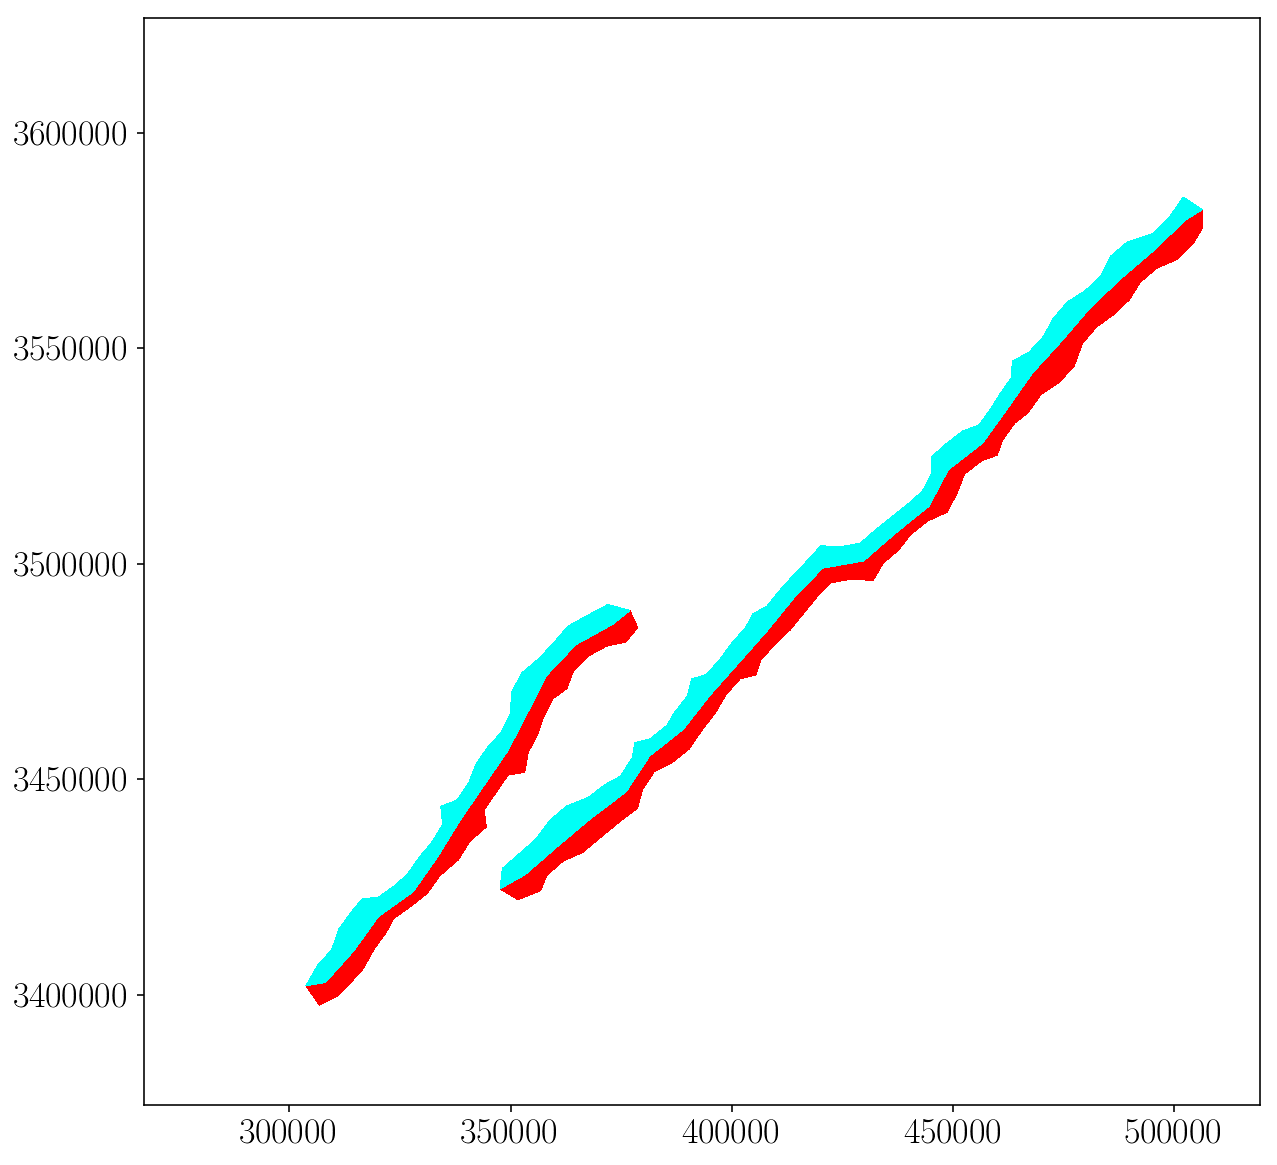

In [242]:
C = np.ones(m_pts.shape[0])
plt.figure(figsize = (10, 10))
for i in range(2):
    which_tris = m_tris[side == i + 1]
    if which_tris.shape[0] == 0:
        continue
    plt.tripcolor(m_pts[:,0], m_pts[:,1], which_tris, C * i, vmin = 0, vmax = 2, cmap = 'hsv')
vW = 0.9 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.show()

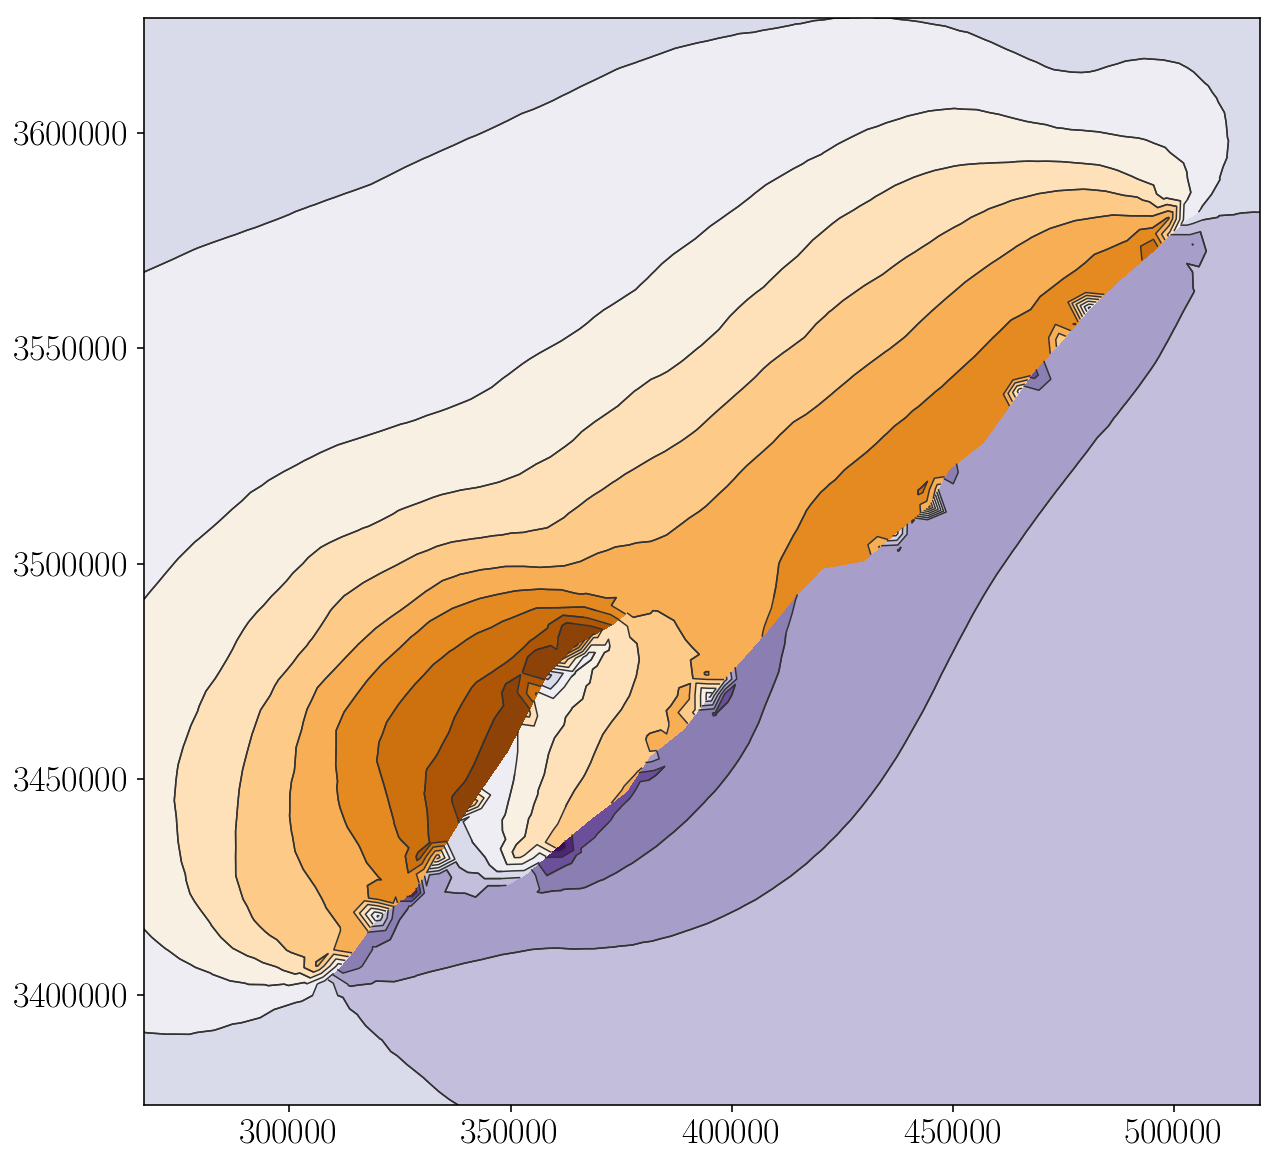

In [248]:
plt.figure(figsize = (10, 10))
d = 0

for i in range(2):
    which_tris = np.where(np.logical_or(side[:fault_start_idx] == 0, side[:fault_start_idx] == i + 1))[0]
    reduced_m = remove_unused_pts((m_pts, m_tris[which_tris]))
    soln_vals = np.empty(reduced_m[0].shape[0])
    soln_vals[reduced_m[1]] = soln.reshape((-1, 3, 3))[which_tris, :, d]
    
#       triang = tri.Triangulation(reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1])
#     refiner = tri.UniformTriRefiner(triang)
#     # tri_refi, interp_vals = refiner.refine_field(field, subdiv=2)
#     #tri_refi, interp_vals = triang, field
#     interp = tri.LinearTriInterpolator(triang, field)
#     tri_refi, interp_vals = refiner.refine_field(field, triinterpolator = interp, subdiv = 2)

#     cntf = plt.tricontourf(tri_refi, interp_vals, cmap = cmap, levels = levels)
#     plt.tricontour(
#         tri_refi, interp_vals,
#         levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
#     )
    
    cntf = plt.tricontourf(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        cmap = cmap, levels = levels
    )
    plt.tricontour(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
    )
vW = 0.9 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.show()

In [67]:
touching_fault = np.unique(connectivity.row[fault_touching_pair])

touching_fault_conn = np.array(tri_connectivity_graph(m_tris[touching_fault]).todense())

color = np.zeros(touching_fault.shape[0], dtype = np.int)
n_colors = 8
for i in range(touching_fault.shape[0]):
    available_colors = list(range(n_colors))
    touching_indices = np.where(touching_fault_conn[i,:])[0]
    for j in touching_indices:
        if j >= i:
            continue
        if color[j] in available_colors:
            available_colors.remove(color[j])
    color[i] = np.min(available_colors)

view_center = np.mean(refined_fault_m[0], axis = 0)
fault_L = np.max(np.sqrt(np.sum((refined_fault_m[0] - view_center) ** 2, axis = 1)))

C = np.ones(m_pts.shape[0])
plt.figure(figsize = (10, 10))
for i in range(n_colors):
    which_tris = m_tris[touching_fault[color == i]]
    if which_tris.shape[0] == 0:
        continue
    plt.tripcolor(m_pts[:,0], m_pts[:,1], which_tris, C * i, vmin = 0, vmax = n_colors, cmap = 'hsv')
vW = 0.9 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.show()

plt.figure(figsize = (10, 10))
d = 0

for i in range(n_colors):
    which_tris = np.array(list(
        (set(range(fault_start_idx)) - set(touching_fault.tolist())).union(
            set(touching_fault[color == i])
        )
    ), dtype = np.int)
    reduced_m = remove_unused_pts((m_pts, m_tris[which_tris]))
    soln_vals = np.empty(reduced_m[0].shape[0])
    soln_vals[reduced_m[1]] = soln.reshape((-1, 3, 3))[which_tris, :, d]
    
#       triang = tri.Triangulation(reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1])
#     refiner = tri.UniformTriRefiner(triang)
#     # tri_refi, interp_vals = refiner.refine_field(field, subdiv=2)
#     #tri_refi, interp_vals = triang, field
#     interp = tri.LinearTriInterpolator(triang, field)
#     tri_refi, interp_vals = refiner.refine_field(field, triinterpolator = interp, subdiv = 2)

#     cntf = plt.tricontourf(tri_refi, interp_vals, cmap = cmap, levels = levels)
#     plt.tricontour(
#         tri_refi, interp_vals,
#         levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
#     )
    
    cntf = plt.tricontourf(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        cmap = cmap, levels = levels
    )
    plt.tricontour(
        reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals,
        levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
    )
vW = 0.5 * fault_L
plt.xlim([view_center[0] - vW, view_center[0] + vW])
plt.ylim([view_center[1] - vW, view_center[1] + vW])
plt.show()

In [9]:
surf_pts_map = np.unique(m_tris[:fault_start_idx])
surf_pts = m_pts[surf_pts_map]
surf_disp_all = np.empty((np.max(surf_pts_map) + 1, 3))
surf_disp_all[m_tris[:fault_start_idx], :] = soln.reshape((-1, 3, 3))[:fault_start_idx]
surf_disp = surf_disp_all[surf_pts_map]

import matplotlib.tri as tri
cmap = 'PuOr'
for d in range(1):
    field = surf_disp[:,d]
    levels = np.linspace(np.min(field), np.max(field), 17)
    plt.figure(figsize = (10,10))
    triang = tri.Triangulation(surf_pts[:,0], surf_pts[:,1])
    refiner = tri.UniformTriRefiner(triang)
    # tri_refi, interp_vals = refiner.refine_field(field, subdiv=2)
    #tri_refi, interp_vals = triang, field
    interp = tri.LinearTriInterpolator(triang, field)
    tri_refi, interp_vals = refiner.refine_field(field, triinterpolator = interp, subdiv = 2)

    # plt.tripcolor(tri_refi, interp_vals)
    cntf = plt.tricontourf(tri_refi, interp_vals, cmap = cmap, levels = levels)
    plt.tricontour(
        tri_refi, interp_vals, 
        levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 0.75
    )
    #plt.triplot(triang, linewidth = 0.5)
    plt.title('$u_' + ['x', 'y', 'z'][d] + '$')
    plt.colorbar(cntf)
    vW = 0.5 * fault_L
    plt.xlim([view_center[0] - vW, view_center[0] + vW])
    plt.ylim([view_center[1] - vW, view_center[1] + vW])
    plt.show()